## Exercise 2 - Let's describe features and find correspondences

Now let's see the code for SIFT feature descriptor. We will use cv2 module because it has many convinient cv-related functions. Installation guide can be found here: https://pypi.org/project/opencv-python/<br>
Several images are prepared for you to try, under <b>test</b> folder. I would like you to write a code that find correspondences between the two images and stitch them accordingly, like panorama stitching.

| Source | Target | Source | Target | Source | Target | 
| ---- | ---- | ---- | ---- |  ---- | ---- | 
|<img src="test/box.png" style="width:100px"> | <img src="test/box_in_scene.png"  style="width:100px"> | <img src="test/pj/Rainier1.png"  style="width:100px"> | <img src="test/pj/Rainier2.png"  style="width:100px"> | <img src="test/mb/100-0023_img.jpg"  style="width:100px"> | <img src="test/mb/100-0024_img.jpg"  style="width:100px"> |

The images in <b>test</b> folder are from the URL below. 
 * https://github.com/rmislam/PythonSIFT 
 * https://github.com/pjreddie/uwimg/ 
 * http://matthewalunbrown.com/autostitch/autostitch.html

-----

Below is the code based on https://github.com/rmislam/PythonSIFT which is shared for educational purposes but also allow commercial use (you can clone the code from the git repository as well), and to understand the code, the following introduction by OpenCV will be a good guide for you.
 * https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html

If you like to read David Lowe's original paper, here it is: https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf <br>
(This paper has been cited 62,312 times according to google scholar, and is definitely one of the most influential papers in computer vision).

Below, in <b>computeKeypointsAndDescriptors</b>, from <b>generateBaseImage</b> until <b>convertKeypointsToInputImageSize</b> are for finding a local extrema to locate keypoints and finding its scale, and <b>generateDescriptors</b> is constructing features that we learned in detail in the class.

In [19]:
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging

####################
# Global variables #
####################

logger = logging.getLogger(__name__)
float_tolerance = 1e-7

#################
# Main function #
#################

def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    """Compute SIFT keypoints and descriptors for an input image
    """
    image = image.astype('float32')
    base_image = generateBaseImage(image, sigma, assumed_blur)
    num_octaves = computeNumberOfOctaves(base_image.shape)
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    keypoints = removeDuplicateKeypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors

#########################
# Image pyramid related #
#########################

def generateBaseImage(image, sigma, assumed_blur):
    """Generate base image from input image by upsampling by 2 in both directions and blurring
    """
    logger.debug('Generating base image...')
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  # the image blur is now sigma instead of assumed_blur

def computeNumberOfOctaves(image_shape):
    """Compute number of octaves in image pyramid as function of base image shape (OpenCV default)
    """
    return int(round(log(min(image_shape)) / log(2) - 1))

def generateGaussianKernels(sigma, num_intervals):
    """Generate list of gaussian kernels at which to blur the input image. Default values of sigma, intervals, and octaves follow section 3 of Lowe's paper.
    """
    logger.debug('Generating scales...')
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images
    """
    logger.debug('Generating Gaussian images...')
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return array(gaussian_images, dtype=object)

def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    logger.debug('Generating Difference-of-Gaussian images...')
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return array(dog_images, dtype=object)

###############################
# Scale-space extrema related #
###############################

def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid
    """
    logger.debug('Finding scale-space extrema...')
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
    """
    logger.debug('Localizing scale-space extrema...')
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), 
    where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), 
    where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
    # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
    # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
    # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

#########################
# Keypoint orientations #
#########################

def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, 
                                     num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    logger.debug('Computing keypoint orientations...')
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  
    # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

##############################
# Duplicate keypoint removal #
##############################

def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

#############################
# Keypoint scale conversion #
#############################

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

#########################
# Descriptor generation #
#########################

def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    logger.debug('Generating descriptors...')
    descriptors = []

    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

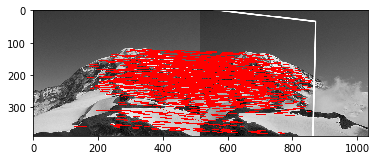

In [20]:
import numpy as np
import cv2
#import pysift
from matplotlib import pyplot as plt
import logging
logger = logging.getLogger(__name__)

MIN_MATCH_COUNT = 10

#img1 = cv2.imread('test/box.png', 0)           # queryImage
#img2 = cv2.imread('test/box_in_scene.png', 0)  # trainImage
#img1 = cv2.imread('test/mb/100-0023_img.jpg', 0)  # queryImage
#img2 = cv2.imread('test/mb/100-0024_img.jpg', 0)  # trainImage
img1 = cv2.imread('test/pj/Rainier1.png', 0)  # queryImage
img2 = cv2.imread('test/pj/Rainier2.png', 0)  # trainImage


# Compute SIFT keypoints and descriptors
#kp1, des1 = pysift.computeKeypointsAndDescriptors(img1)
#kp2, des2 = pysift.computeKeypointsAndDescriptors(img2)
kp1, des1 = computeKeypointsAndDescriptors(img1)
kp2, des2 = computeKeypointsAndDescriptors(img2)

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2

    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (255, 0, 0))

    plt.imshow(newimg)
    plt.show()
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))

In [21]:
from PIL import Image
saveImg = Image.fromarray(newimg)
saveImg.save('sift_result.png')

If you understand the algorithm, below runs much faster!

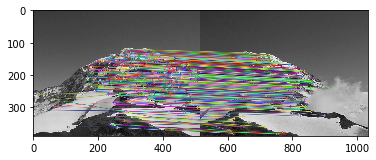

(<matplotlib.image.AxesImage at 0x7f7474d59e10>, None)

In [27]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('test/pj/Rainier1.png',cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('test/pj/Rainier2.png',cv.IMREAD_GRAYSCALE) # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

Try to write your own code that find matches between images and calculate homography transformation that stitch the two images.